# with comms return and action counters

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
import pickle
import os
import itertools
plt.style.use('seaborn-poster')

In [2]:
webplot_dir = './webplot_results'
results_dir = './results'
variants = {'comms_test': 'comms_test'}
total_steps = 1e8

# Bard & Foerster Results

In [3]:
webplot_data = {}
for i in range(2,6):
    dat = np.genfromtxt(os.path.join(webplot_dir, '{}player_data.csv').format(i), delimiter=',')
    webplot_data['{} players'.format(i)] = dat

Text(0.5, 1.0, 'Bard, Foerster et al.')

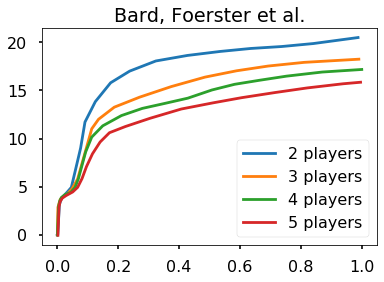

In [4]:
for k, v in webplot_data.items():
    plt.plot(v[:,0], v[:,1], label=k)

plt.legend()
plt.title("Bard, Foerster et al.")

# Theory of Mind Results

In [5]:
experiment = {}

for label, path in variants.items():
    log_dir = os.path.join(results_dir, path)
    dat = pickle.load(open(os.path.join(log_dir, sorted(os.listdir(log_dir))[-1]), 'rb'))
    dat = sorted(dat.items(), key=lambda v: int(v[0].split("iter")[-1]))
    
    # cumulative timesteps per iteration
    ts = np.cumsum([np.sum(d[1]['train_episode_lengths']) for d in dat])
    
    # average episode length
    ep_lens_avg = np.array([np.mean(d[1]['train_episode_lengths']) for d in dat])
    
    # average extrinsic reward
    avg_return = np.array([d[1]['average_return'] for d in dat])
    
    # average intrinsic reward
    avg_comms_return = np.array([np.mean(d[1]['train_epsisode_comms_returns']) for d in dat])
    
    # move counts
    move_counts = [d[1]['train_move_counts'] for d in dat]
    
    experiment[label] = {'avg_return': avg_return,
                         'avg_comms_return': avg_comms_return,
                         'cumulative_steps': ts, 
                         'ep_lens': ep_lens_avg,
                         'move_counts': move_counts}
    
percent_complete = {v: experiment[v]['cumulative_steps'] / total_steps for v in variants}
run_lens = {k: len(v) for k,v in percent_complete.items()}
iterations = percent_complete[max(run_lens, key=run_lens.get)]

# Results

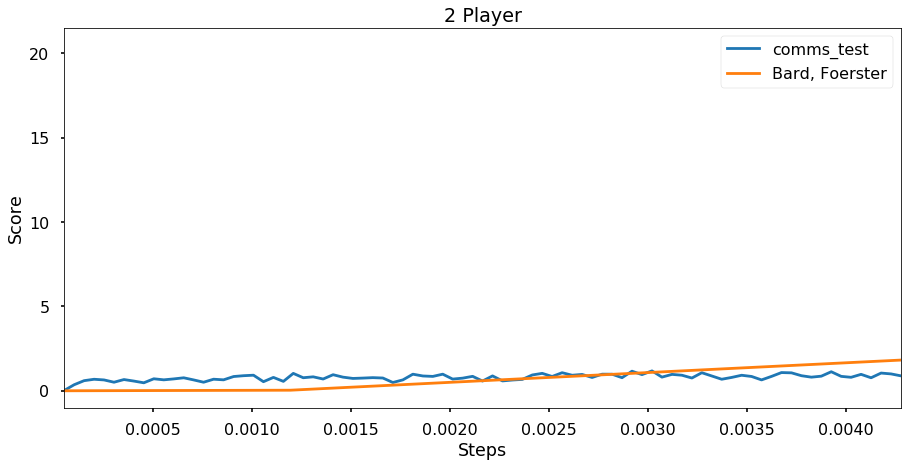

In [6]:
window = 1

avg_ret = np.array([experiment[v]['avg_return'] for v in variants])
ret_dict = {v: np.squeeze(avg_ret[i]) for i, v in enumerate(variants)}

df = pd.DataFrame.from_dict(ret_dict, orient='index').T
df['iterations'] = iterations
df = df.set_index('iterations')

ax = df.rolling(window).mean().plot(figsize=(15,7))
plt.plot(webplot_data['2 players'][:,0], 
         webplot_data['2 players'][:,1],
         label='Bard, Foerster')
plt.title('2 Player')
plt.ylabel('Score')
plt.xlabel('Steps')

plt.legend()

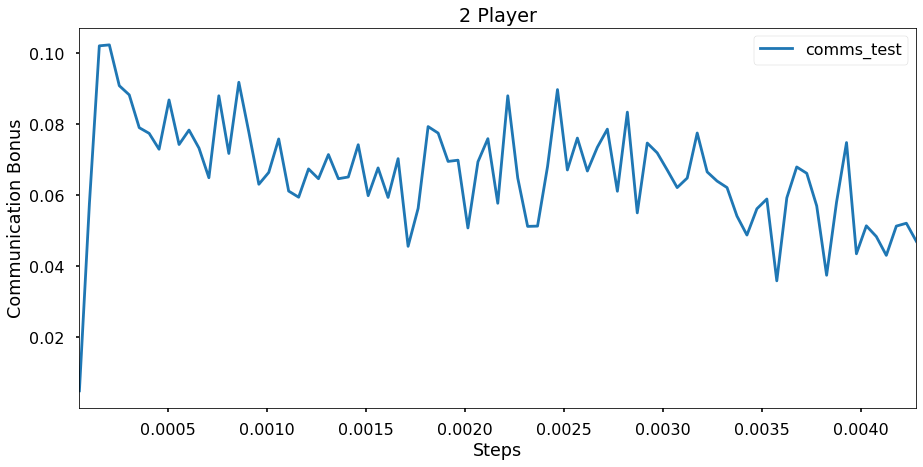

In [7]:
window = 1

avg_ret = np.array([experiment[v]['avg_comms_return'] for v in variants])
ret_dict = {v: np.squeeze(avg_ret[i]) for i, v in enumerate(variants)}

df = pd.DataFrame.from_dict(ret_dict, orient='index').T
df['iterations'] = iterations
df = df.set_index('iterations')

ax = df.rolling(window).mean().plot(figsize=(15,7))

plt.title('2 Player')
plt.ylabel('Communication Bonus')
plt.xlabel('Steps')

plt.legend()

Text(0.5, 0, 'Steps')

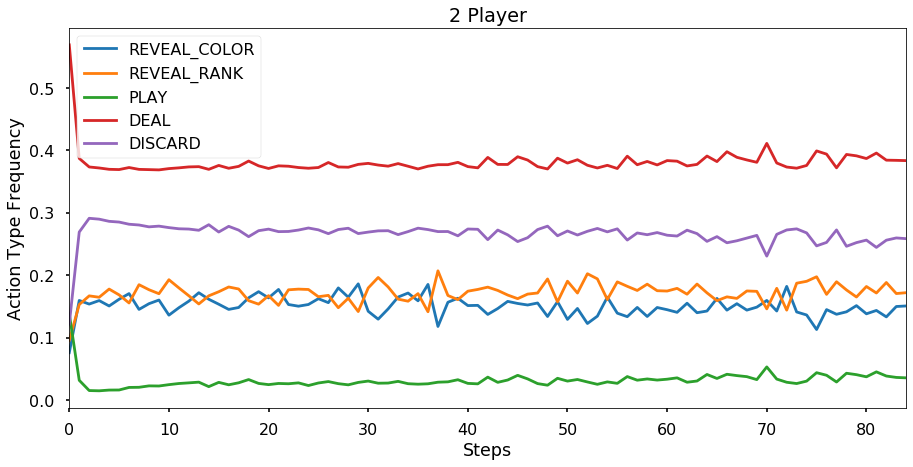

In [8]:
exp_lab = 'comms_test'
dat = experiment[exp_lab]['move_counts']
action_ratios = []
for d in dat:
    dat = pd.DataFrame(d).fillna(0).sum()
    action_ratios.append(dict(dat / dat.sum()))
dat = pd.DataFrame(action_ratios)
dat.plot(figsize=(15,7))
plt.title('2 Player')
plt.ylabel('Action Type Frequency')
plt.xlabel('Steps')

(50, 100)

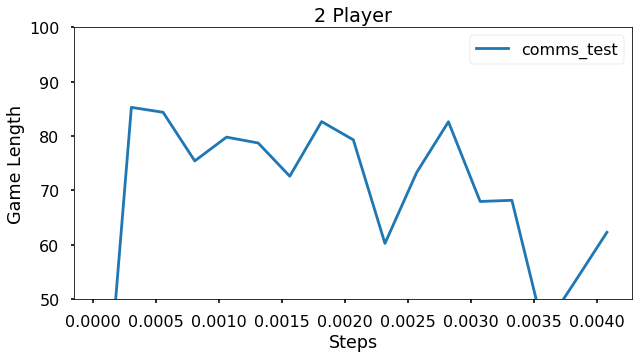

In [9]:
plt.figure(figsize=(10,5))
resample = 5
for v in variants:
    plt.plot(experiment[v]['cumulative_steps'][::resample] / total_steps, 
                 experiment[v]['ep_lens'][::resample],
             label=v)

plt.legend()
plt.title('2 Player')
plt.ylabel('Game Length')
plt.xlabel('Steps')
plt.ylim((50,100))